In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import pickle
import inspect

%matplotlib inline

In [3]:
TRAIN_NUM_EXAMPLES = 20_000_000
TRAIN_NUM_WORDS = 200_000
VAL_NUM_WORDS = 3_000
LOAD_DATA_FROM_CACHE = True  # Set to False to recompute the data and save to disk

current_dir = os.getcwd()
train_dataset_path = f"{current_dir}/train_dataset.pkl"
val_dataset_path = f"{current_dir}/val_dataset.pkl"

In [4]:
# load the data in training_dictionary.txt
with open(f"{current_dir}/training_dictionary.txt", "r") as file:
    all_words = file.read().splitlines()
print(len(all_words))

224377


100%|██████████| 224377/224377 [00:00<00:00, 4743139.84it/s]

count    224377.000000
mean          9.591540
std           2.916634
min           1.000000
25%           8.000000
50%           9.000000
75%          11.000000
max          24.000000
Name: word_length, dtype: float64


array([[<Axes: title={'center': 'word_length'}>]], dtype=object)

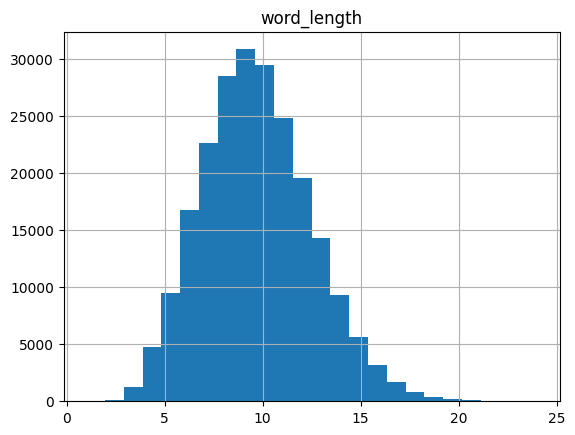

In [5]:
import pandas as pd

df = pd.DataFrame(
    {
        "word_length": [len(word) for word in tqdm(all_words)],
    }
)

print(df["word_length"].describe())

df.hist(column="word_length", bins=df["word_length"].max())

In [6]:
max_length = 25

words = [word for word in all_words if len(word) <= max_length]

In [7]:
import random

print(len(words))
random.seed(42)
random.shuffle(words)
words[:10]

224377


['reperplex',
 'dice',
 'hemibenthic',
 'plumatellid',
 'delatinize',
 'mermithization',
 'rixatrix',
 'preassurance',
 'desensitize',
 'mele']

In [8]:
len("".join(words))

2152121

In [9]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

tetraiodophenolphthalein 24


In [10]:
vocab = set("".join(words))
vocab = [".", "_"] + sorted(list(vocab))
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

29
{'.': 0, '_': 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
{0: '.', 1: '_', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


In [11]:
# create a dataset where each character is masked with an underscore
block_size = max_length

In [12]:
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    if len(word) < block_size:
        word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:30]

224377


['reperplex................',
 'dice.....................',
 'hemibenthic..............',
 'plumatellid..............',
 'delatinize...............',
 'mermithization...........',
 'rixatrix.................',
 'preassurance.............',
 'desensitize..............',
 'mele.....................',
 'codfisher................',
 'metrorrhagia.............',
 'dispiece.................',
 'malagigi.................',
 'undetractingly...........',
 'vanillal.................',
 'dowery...................',
 'blepharal................',
 'osnappar.................',
 'phoronic.................',
 'behold...................',
 'brigand..................',
 'lots.....................',
 'thingamabob..............',
 'aureation................',
 'phosphene................',
 'kolach...................',
 'raja.....................',
 'rhipiphorid..............',
 'unagitatedly.............']

In [13]:
def masked_words(word: str):
    if not word:
        return []

    result = []

    # Get unique characters in the word
    unique_chars = list(set(word) - {"."})

    # Generate all possible combinations of which characters to mask
    # For n unique characters, we have 2^n possibilities
    for i in range(1, 2 ** len(unique_chars)):  # Start from 1 to exclude no masks
        chars_to_mask = set()

        # Determine which characters to mask based on bit pattern
        for j in range(len(unique_chars)):
            if i & (1 << j):
                chars_to_mask.add(unique_chars[j])

        # Create the masked string
        masked = ""
        for char in word:
            if char in chars_to_mask:
                masked += "_"
            else:
                masked += char

        # Create a tuple for each masked character type
        # for char in chars_to_mask:
        result.append((masked, word))

    return result


print(masked_words("app"))
print(masked_words("app."))
print(masked_words("xyz"))
print(masked_words("xyz.."))

[('_pp', 'app'), ('a__', 'app'), ('___', 'app')]
[('_pp.', 'app.'), ('a__.', 'app.'), ('___.', 'app.')]
[('xy_', 'xyz'), ('x_z', 'xyz'), ('x__', 'xyz'), ('_yz', 'xyz'), ('_y_', 'xyz'), ('__z', 'xyz'), ('___', 'xyz')]
[('xy_..', 'xyz..'), ('x_z..', 'xyz..'), ('x__..', 'xyz..'), ('_yz..', 'xyz..'), ('_y_..', 'xyz..'), ('__z..', 'xyz..'), ('___..', 'xyz..')]


In [14]:
%%time

def gen_dataset(truncated_words: list[str]):
    dataset = []
    for word in truncated_words:
        dataset.extend(masked_words(word))
    return dataset


# dataset = list(set(dataset))

if not LOAD_DATA_FROM_CACHE:
    # print the first 10 elements of the dataset
    train_dataset = gen_dataset(truncated_words[:TRAIN_NUM_WORDS])
    print(len(train_dataset))
    print(train_dataset[:10])

    val_dataset = gen_dataset(truncated_words[-VAL_NUM_WORDS:])
    print(len(val_dataset))
    print(val_dataset[:10])

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 12.6 μs


In [15]:
%%time

random.seed(42)
if not LOAD_DATA_FROM_CACHE:
  random.shuffle(train_dataset)
  train_dataset = train_dataset[:TRAIN_NUM_EXAMPLES]

CPU times: user 16 μs, sys: 11 μs, total: 27 μs
Wall time: 30.5 μs


In [16]:
%%time
# convert the words to a list of ints
def integerize_dataset(dataset: list[tuple[str, str]]):
    integerized_dataset = []
    for word, label in dataset:
        integerized_dataset.append(
            ([stoi[char] for char in word], [stoi[char] for char in label])
        )
    return integerized_dataset

if not LOAD_DATA_FROM_CACHE:
    train_integerized_dataset = integerize_dataset(train_dataset)
    print(train_integerized_dataset[0])

    val_integerized_dataset = integerize_dataset(val_dataset)
    print(val_integerized_dataset[0])

CPU times: user 6 μs, sys: 4 μs, total: 10 μs
Wall time: 14.3 μs


In [17]:
%%time

if not LOAD_DATA_FROM_CACHE:
  random.shuffle(train_integerized_dataset)
  random.shuffle(val_integerized_dataset)

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 10.5 μs


In [18]:
%%time
if LOAD_DATA_FROM_CACHE:
    print(f"Loading train dataset from {train_dataset_path}")
    with open(train_dataset_path, "rb") as f:
        train_integerized_dataset = pickle.load(f)

    print(f"Loading val dataset from {val_dataset_path}")
    with open(val_dataset_path, "rb") as f:
        val_integerized_dataset = pickle.load(f)
else:
    print(f"Saving train dataset to {train_dataset_path}")
    with open(train_dataset_path, "wb") as f:
        pickle.dump(train_integerized_dataset, f)

    print(f"Saving val dataset to {val_dataset_path}")
    with open(val_dataset_path, "wb") as f:
        pickle.dump(val_integerized_dataset, f)

Loading train dataset from /home/ubuntu/transformer-hangman-solver/train_dataset.pkl
Loading val dataset from /home/ubuntu/transformer-hangman-solver/val_dataset.pkl
CPU times: user 24.4 s, sys: 7.67 s, total: 32 s
Wall time: 30.7 s


In [19]:
%%time
# create a pytorch dataset of word and label pairs

class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = HangmanDataset(train_integerized_dataset)
val_dataset = HangmanDataset(val_integerized_dataset)

print(len(train_dataset))
print(len(val_dataset))

20000000
1406556
CPU times: user 1min 18s, sys: 2.68 s, total: 1min 21s
Wall time: 1min 21s


In [39]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from tqdm import tqdm
import time


@dataclass
class GPTConfig:
    block_size: int = 1024  # Max sequence length
    vocab_size: int = (
        50257  # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    )
    n_layer: int = 12  # number of layers
    n_head: int = 12  # number of attention heads
    n_embd: int = 768  # embedding dimension


class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) is the embedding dimension
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # att = (q @ k.transpose(-2, -1)) * (1 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        # att = F.softmax(att, dim=-1)
        # y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)

        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y


class ReLUSquared(nn.ReLU):
    def forward(self, x):
        return super().forward(x) ** 2


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        # self.gelu = nn.GELU(approximate="tanh")
        self.relu_sq = ReLUSquared()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        # x = self.gelu(x)
        x = self.relu_sq(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        # self.attn = MultiHeadLatentAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=nn.LayerNorm(config.n_embd),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02  # roughly equivalent to 1/sqrt(d_model)
            if hasattr(module, "NANOGPT_SCALE_INIT"):
                std *= (2 * self.config.n_layer) ** -0.05
            torch.nn.init.normal_(
                module.weight,
                mean=0.0,
                std=std,
            )
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(
                module.weight,
                mean=0.0,
                std=0.02,  # roughly equivalent to 1/sqrt(d_model)
            )

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor of integers token indices
        B, T = idx.size()
        assert (
            T <= self.config.block_size
        ), f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (T, n_embed)
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (B, T, n_embed)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layer norm and the classifier
        x = self.transformer.ln_f(x)  # (B, T, n_embed)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        letter_indices = idx != stoi["."]

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits[letter_indices].view(-1, logits[letter_indices].size(-1)),
                targets[letter_indices].view(-1),
            )
        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameter that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for p in param_dict.values() if p.dim() >= 2]
        nodecay_params = [p for p in param_dict.values() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": nodecay_params, "weight_decay": 0.0},
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(
            f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
        )
        print(
            f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
        )
        # Create AdamW optimizer and use the fused version if it is available and on an CUDA device
        fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(
            optim_groups, lr=learning_rate, fused=use_fused, betas=(0.9, 0.95), eps=1e-8
        )
        return optimizer

In [41]:
import deepseek.model as deepseek_model
from deepseek.model import Transformer as DeepSeekTransformer

# Create a transformer model for the hangman game

d_model = 512
nhead = 8
num_layers = 8

batch_size = 4096
num_epochs = 1

max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = len(train_dataset) // batch_size * num_epochs

device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

print("Using device:", device)

torch.set_float32_matmul_precision("high")

opt_vocab_size = 64  # vocab_size
opt_block_size = 64  # block_size

# create a GPT model

model = GPT(
    GPTConfig(
        block_size=opt_block_size,
        vocab_size=opt_vocab_size,
        n_layer=num_layers,
        n_head=nhead,
        n_embd=d_model,
    )
)
# model_args = deepseek_model.ModelArgs(
#     max_batch_size=batch_size,
#     max_seq_len=64,
#     dtype="fp8",
#     vocab_size=64,
#     dim=d_model,
#     inter_dim=d_model * 2,
#     moe_inter_dim=d_model,
#     n_layers=4,
#     n_heads=nhead,
#     original_seq_len=block_size,
#     n_routed_experts=2,
#     n_shared_experts=2,
#     n_activated_experts=2,
#     padding_token_id=stoi["."],
# )
# model = DeepSeekTransformer(model_args)
print("Number of parameters:", f"{sum(p.numel() for p in model.parameters()):,}")

model.to(device)
model = torch.compile(model)
# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8, weight_decay=0.0, fused=True)
optimizer = model.configure_optimizers(
    weight_decay=0.1, learning_rate=6e-4, device_type=device
)

# train the model


def get_lr(it):
    # 1) linear warmup for warmup_steps
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    # 2) if it > lr_decay_steps, return min_lr
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (
        1.0 + math.cos(math.pi * decay_ratio)
    )  # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)


lossi = []
val_lossi = []
val_acci = []
val_step = []

val_features, val_labels = val_dataset[:batch_size]
val_features = val_features.to(device)
val_labels = val_labels.to(device)
step = 0
for epoch in range(num_epochs):
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        t0 = time.time()
        # idx = torch.randint(0, len(train_dataset), (batch_size,))
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            # print("inputs", features.shape, labels.shape)
            logits, loss = model(features, labels)

        # Backward pass
        loss.backward()

        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # detemine the learning rate for this step
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # Update weights
        optimizer.step()
        torch.cuda.synchronize()

        t1 = time.time()
        dt = (t1 - t0) * 1000  # ms
        lossi.append(loss.item())

        if step % 20 == 0:
            model.eval()
            with torch.no_grad():
                val_step.append(step)
                val_logits, val_loss = model(val_features, val_labels)
                val_lossi.append(val_loss.item())
                # calculate the accuracy of predicting the correct hidden letters
                hidden_letter_indices = val_features == stoi["_"]
                val_preds = torch.argmax(torch.softmax(val_logits, dim=-1), dim=-1)
                val_acc = (
                    (
                        val_preds[hidden_letter_indices]
                        == val_labels[hidden_letter_indices]
                    )
                    .float()
                    .mean()
                )
                val_acci.append(val_acc.item())
            model.train()

        tokens_per_second = (batch_size * block_size) / (t1 - t0)
        step += 1
        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} | Step {step:4d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f} | LR: {lr:.4e} | Norm: {norm:.4f} | {dt:.2f}ms/batch | {tokens_per_second:.2f} tok/s"
        )
        # if step >= 2:
        #     break

Using device: cuda
Number of parameters: 25,285,632
num decayed parameter tensors: 34, with 25,231,360 parameters
num non-decayed parameter tensors: 66, with 54,272 parameters
using fused AdamW: True


  0%|          | 0/4883 [00:00<?, ?it/s]/home/ubuntu/transformer-hangman-solver/.venv/lib/python3.12/site-packages/torch/_dynamo/variables/functions.py:1263: UserWarning: Dynamo does not know how to trace the builtin `<unknown module>.Tensor.view.` This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind).
If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround.
If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use `torch.compiler.allow_in_graph`.
  torch._dynamo.utils.warn_once(explanation + "\n" + "\n".join(hints))
Epoch 1/1 | Step    7 | Train Loss: 2.8850 | Val Loss: 3.3468 | Val Acc: 0.0919 | LR: 4.2000e-04 | Norm: 2.9115 | 135.75ms/batch | 754330.15 t

In [42]:
model_path = f"{current_dir}/model.pth"
torch.save(model.state_dict(), model_path)

In [43]:
# # clear gpu mem
# model.clear_caches()
# del model
# import gc

# gc.collect()
# torch.cuda.empty_cache()

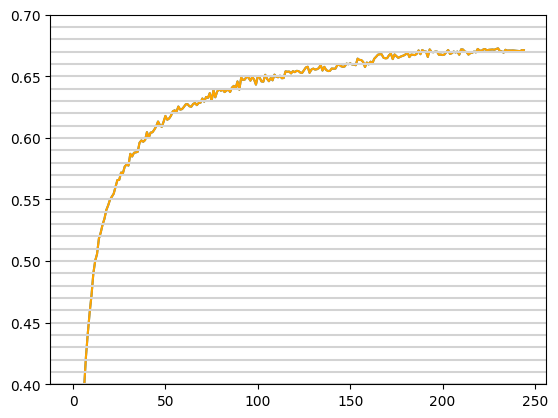

In [46]:
plt.plot(val_acci)
plt.plot(val_acci, color="orange")
plt.ylim(0.4, 0.7)
# show horizontal line every 0.01
for i in range(40, 70, 1):
    plt.axhline(i / 100, color="lightgray", linestyle="-")
plt.show()

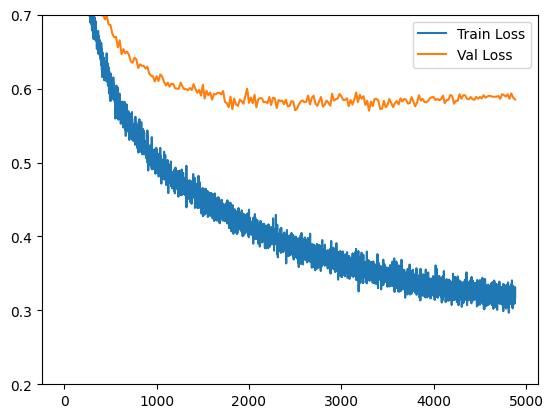

In [47]:
plt.plot(lossi)
plt.plot(val_step, val_lossi)
plt.legend(["Train Loss", "Val Loss"])
plt.ylim(0.2, 0.7)
plt.show()

In [48]:
def full_eval(dataset, batch_size=1024 * 4):
    model.eval()
    with torch.no_grad():
        losses = []
        for i in (pbar := tqdm(range(0, 100000, batch_size))):
            features, labels = dataset[i : i + batch_size]
            features = features.to(device)
            labels = labels.to(device)
            logits, loss = model(features, labels)
            losses.append(loss.item())
        print(np.mean(losses))


full_eval(train_dataset)
full_eval(val_dataset)

print("\n")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 19.04it/s]


0.3187391710281372


100%|██████████| 25/25 [00:01<00:00, 18.93it/s]

0.5792014694213867




In [53]:
# inference:


def predict(model, word, max_guesses=6, verbose=False):
    if verbose:
        print(
            f"{''.join(c for c in word if c != '.')} | {max_guesses} incorrect guesses allowed"
        )
    guesses = []
    model.eval()
    # model.to(device)
    i = 0
    with torch.no_grad():
        while True:
            i += 1
            # print(guesses)
            masked_word = "".join(
                ["_" if char != "." and char not in guesses else char for char in word]
            )
            if verbose:
                print(
                    f"{''.join(c for c in masked_word if c != '.')} | correct guesses: {[c for c in guesses if c in word]} ; incorrect guesses: {[c for c in guesses if c not in word]}"
                )
            if masked_word == word:
                break
            if len([g for g in guesses if g not in word]) >= max_guesses:
                break

            integerized_word = [stoi[c] for c in masked_word]
            features = torch.tensor([integerized_word])
            features = features.to(device)
            logits, _ = model(features)
            probs = torch.softmax(logits[0], dim=-1)

            mask_indices = [i for i, c in enumerate(masked_word) if c == "_"]
            ensemble_probs = torch.mean(probs[mask_indices], dim=0)
            topk_probs, topk_indices = torch.topk(
                ensemble_probs, k=opt_vocab_size, dim=-1
            )
            letter_guesses = [
                (itos[int(idx.item())], f"{p.item() * 100:.2f}%")
                for idx, p in zip(topk_indices, topk_probs)
                if int(idx.item()) in itos
            ]
            letter_guesses = [
                (letter_guess, prob)
                for letter_guess, prob in letter_guesses
                if letter_guess not in guesses and letter_guess not in [".", "_"]
            ]
            # print(sum([p.item() for p in topk_probs]))
            # letter_guesses.sort(key=lambda x: x[1], reverse=True)
            if verbose:
                print(
                    "Next guess probabilities:",
                    ", ".join(
                        [
                            f"'{letter_guess}': {prob}"
                            for letter_guess, prob in letter_guesses
                        ]
                    ),
                    "\n",
                )
            for letter_guess, _ in letter_guesses:
                guesses.append(letter_guess)
                if (
                    letter_guess in word
                    or len([g for g in guesses if g not in word]) == max_guesses
                ):
                    break

    if verbose:
        if masked_word == word:
            print("SUCCESS!")
        else:
            print("FAILED!")
    return masked_word, guesses


predict(model, truncated_words[-VAL_NUM_WORDS * 2], max_guesses=6, verbose=True)


def compute_winrate(words: list[str]):
    wins = 0
    total = 0
    for word in (pbar := tqdm(words)):
        masked_word, guesses = predict(model, word, max_guesses=6, verbose=False)
        if masked_word == word:
            wins += 1
        total += 1
        pbar.set_description(f"Win rate: {wins / total * 100:.2f}%")


print("\n")
print("=" * 100)
print("Computing win rates:")
print("In sample")
compute_winrate(truncated_words[:3000])
print("Out of sample")
compute_winrate(truncated_words[-VAL_NUM_WORDS * 2 : -VAL_NUM_WORDS])

yellowware | 6 incorrect guesses allowed
__________ | correct guesses: [] ; incorrect guesses: []
Next guess probabilities: 'e': 10.93%, 'i': 8.93%, 'a': 8.32%, 'o': 7.97%, 'r': 7.34%, 'n': 6.80%, 't': 6.69%, 's': 6.46%, 'l': 5.63%, 'c': 4.38%, 'u': 3.84%, 'p': 3.34%, 'm': 3.24%, 'd': 3.05%, 'h': 2.96%, 'y': 2.19%, 'g': 2.05%, 'b': 1.72%, 'f': 1.02%, 'v': 0.77%, 'k': 0.66%, 'w': 0.62%, 'z': 0.47%, 'x': 0.32%, 'q': 0.19%, 'j': 0.11%, '-': 0.00% 

_e_______e | correct guesses: ['e'] ; incorrect guesses: []
Next guess probabilities: 'i': 11.56%, 'r': 9.66%, 't': 9.16%, 'a': 8.98%, 'l': 7.35%, 'o': 6.57%, 'n': 6.04%, 's': 5.38%, 'd': 4.86%, 'c': 4.14%, 'm': 4.13%, 'p': 3.98%, 'b': 3.07%, 'u': 2.97%, 'h': 2.69%, 'g': 2.05%, 'v': 1.95%, 'z': 1.88%, 'f': 1.07%, 'y': 0.72%, 'k': 0.71%, 'w': 0.41%, 'x': 0.33%, 'q': 0.16%, 'j': 0.14%, '-': 0.00% 

_e______re | correct guesses: ['e', 'r'] ; incorrect guesses: ['i']
Next guess probabilities: 'o': 12.26%, 's': 8.26%, 't': 8.13%, 'p': 8.05%, 'u': 7.

Win rate: 72.53%: 100%|██████████| 3000/3000 [00:56<00:00, 53.24it/s]


Out of sample


Win rate: 68.97%: 100%|██████████| 3000/3000 [00:54<00:00, 54.98it/s]
